# Customer Churn Analysis – IBM Telco Dataset
**Notebook 01: Data Cleaning & Exploratory Data Analysis (EDA)**

- Load and inspect dataset
- Handle missing values & type conversions
- Feature engineering (tenure buckets, service counts, etc.)
- Exploratory analysis: churn rates, drivers, risk factors



**01: Import libraries**


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 50)

**02: Load dataset**

In [6]:
df = pd.read_excel("../data/ibm_telco.xlsx")
df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

print("Shape:", df.shape)
df.head(3)

Shape: (7043, 33)


,customerid,count,country,state,city,zip_code,lat_long,latitude,longitude,gender,senior_citizen,partner,dependents,tenure_months,phone_service,multiple_lines,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract,paperless_billing,payment_method,monthly_charges,total_charges,churn_label,churn_value,churn_score,cltv,churn_reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved


**03: Missing values & dtypes**

In [7]:
print("Missing values:\n",df.isna().sum().sort_values(ascending= False).head(10))
print("\nData types:\n", df.dtypes.value_counts())

Missing values:
 churn_reason         5174
online_security         0
cltv                    0
churn_score             0
churn_value             0
churn_label             0
total_charges           0
monthly_charges         0
payment_method          0
paperless_billing       0
dtype: int64

Data types:
 object     24
int64       6
float64     3
Name: count, dtype: int64


**04: Cleaning & feature engineering**

In [9]:
# Standardize Churn Value
df['churn_value'] = df['churn_value'].astype(int)

# Convert to numeric values
df['monthly_cahrges'] = pd.to_numeric(df['monthly_charges'], errors= 'coerce')    # Converts columns into proper numeric format.
df['total_charges'] = pd.to_numeric(df['total_charges'], errors= 'coerce')        # errors='coerce' → replaces invalid entries (like blanks or text) with NaN.
df['tenure_months'] = pd.to_numeric(df['tenure_months'], errors = 'coerce')

# Impute the total charges if missing
df['total_charges'] = df['total_charges'].fillna(df['monthly_charges'] * df['tenure_months'])

# Tenure Buckets
df['tenure_buckets'] = pd.cut(df['tenure_months'],
                                bins = [-1, 3, 6, 12, 24, 48, 1000],
                                labels = ['0-3', '4-6', '7-12', '13-24', '25-48', '49+'])       # Groups customers based on how long they’ve stayed
                        
# Servic count
service_cols = ['phone_service', 'multiple_lines', 'online_security', 'online_backup',
                'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']
df['service_count'] = df[service_cols].apply(lambda r: (r== 'Yes').sum(), axis=1)      # Counts the number of services a customer has signed up for

# Normailsed churn score
df['churn_score_norm'] = df['churn_score'] / 100 # Normalizes the churn score to a 0-1 scale

**05: Churn overview**

In [16]:
# Overall churn
overall_churn = df['churn_value'].mean() * 100
print(f"Overall Churn rate: {overall_churn:.2f}%")

# Churn by Contract
churn_by_contract = df.groupby('contract')['churn_value'].mean() * 100
print("\nChurn by Contract:\n", churn_by_contract.round(2).astype(str) + '%')

# Churn by Tenure Bucket
churn_by_tenure = df.groupby('tenure_buckets', observed=False)['churn_value'].mean() * 100
print("\nChurn by Tenure Bucket:\n", churn_by_tenure.round(2).astype(str) + '%')

Overall Churn rate: 26.54%

Churn by Contract:
 contract
Month-to-month    42.71%
One year          11.27%
Two year           2.83%
Name: churn_value, dtype: object

Churn by Tenure Bucket:
 tenure_buckets
0-3      56.21%
4-6      44.63%
7-12     35.89%
13-24    28.71%
25-48    20.39%
49+       9.51%
Name: churn_value, dtype: object


**06: Visuals**

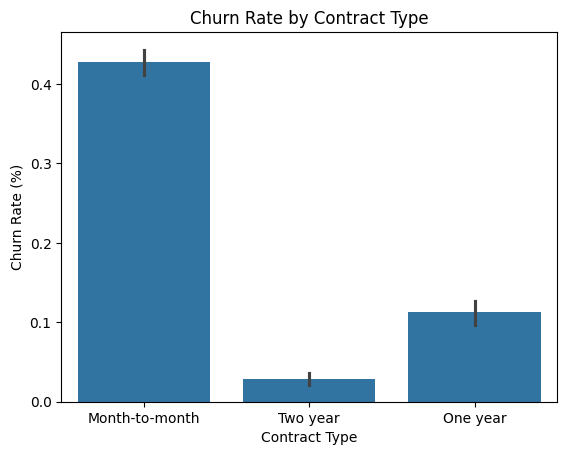

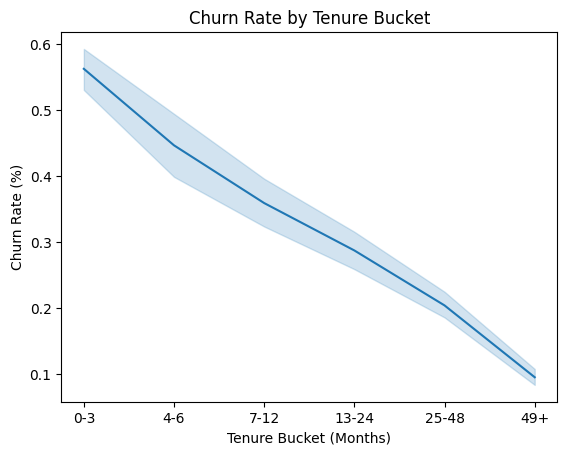

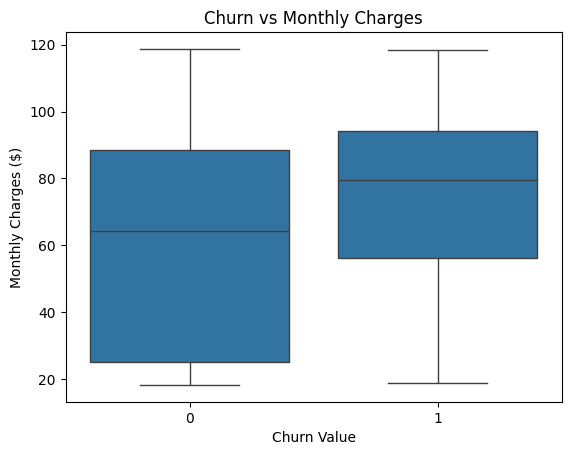

In [ ]:
# Churn by Contract
sns.barplot( data=df, x='contract', y = 'churn_value')
plt.title("Churn Rate by Contract Type")
plt.xlabel("Contract Type")
plt.ylabel("Churn Rate (%)")
plt.show()

# Churn by Tenure Bucket
sns.lineplot(data=df, x='tenure_buckets', y='churn_value', estimator='mean')
plt.title("Churn Rate by Tenure Bucket")
plt.xlabel("Tenure Bucket (Months)")
plt.ylabel("Churn Rate (%)")
plt.show()

# Churn vs Monthly Charges
sns.boxplot(data=df, x='churn_value', y='monthly_charges')
plt.title("Churn vs Monthly Charges")
plt.xlabel("Churn Value")
plt.ylabel("Monthly Charges ()")
plt.show()

**07: Drivers summary**

In [39]:
drivers = ['internet_service', 'payment_method', 'online_security', 'tech_support']

for d in drivers:
    print("==", d)
    churn_rates = df.groupby(d)['churn_value'].mean().sort_values(ascending=False) * 100
    print(churn_rates.round(2).astype(str) + "%")

== internet_service
internet_service
Fiber optic    41.89%
DSL            18.96%
No               7.4%
Name: churn_value, dtype: object
== payment_method
payment_method
Electronic check             45.29%
Mailed check                 19.11%
Bank transfer (automatic)    16.71%
Credit card (automatic)      15.24%
Name: churn_value, dtype: object
== online_security
online_security
No                     41.77%
Yes                    14.61%
No internet service      7.4%
Name: churn_value, dtype: object
== tech_support
tech_support
No                     41.64%
Yes                    15.17%
No internet service      7.4%
Name: churn_value, dtype: object


### 🔹 Service Features Driving Churn
- Customers **without Online Security or Tech Support** churn at a much higher rate.  
- Fiber Optic customers tend to churn more compared to DSL.  
- Customers paying via **Electronic Check** have significantly higher churn.  

**Interpretation:** Add-on services and payment method are key retention levers.  
**Business insight:** Bundling security/tech support with Internet plans and nudging customers to auto-pay can reduce churn.


**08: Save cleaned data**

In [27]:
df.to_csv("../data/ibm_telco_cleaned.csv", index=False)
print("Cleaned dataset saved. Rows:", len(df))

Cleaned dataset saved. Rows: 7043
